# Exploratory Data Analysis: PubMed Abstracts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read in cleaned file
filename = '../data/pubmed_cleaned.csv'

In [3]:
df = pd.read_csv(filename)

In [9]:
df.head() 

,pmid,title,text,date,citations
0,32416782,Artificial intelligence and the future of glob...,Concurrent advances in information technology ...,2020-05-01,10
1,32414188,Future Is Unlicensed: Private 5G Unlicensed Ne...,This paper aims to unlock the unlicensed band ...,2020-05-01,0
2,32413821,A review of modern technologies for tackling C...,Objective: Science and tech...,2020-08-01,23
3,32411818,Report on computational assessment of Tumor In...,Assessment of tumor-infiltrating lymphocytes (...,2020-05-01,3
4,32410553,Application of Artificial Intelligence in Phar...,Background: Artificial inte...,2020-06-01,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2986 entries, 0 to 2985
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pmid       2986 non-null   int64 
 1   title      2986 non-null   object
 2   text       2986 non-null   object
 3   date       2986 non-null   object
 4   citations  2986 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 116.8+ KB


In [11]:
df.isnull().sum()

pmid         0
title        0
text         0
date         0
citations    0
dtype: int64

In [12]:
df.duplicated().sum()

0

#### Explore Proposed Target Variable: 'claps'

In [13]:
df['citations'].value_counts()

0      539
1      384
2      288
3      253
4      183
      ... 
358      1
704      1
63       1
65       1
387      1
Name: citations, Length: 132, dtype: int64

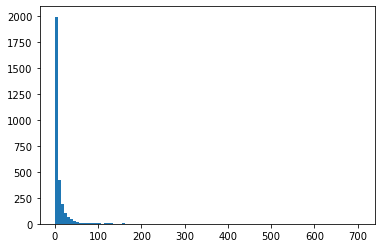

In [14]:
#Look at the distribution of the citations
plt.hist(df['citations'], bins=100);

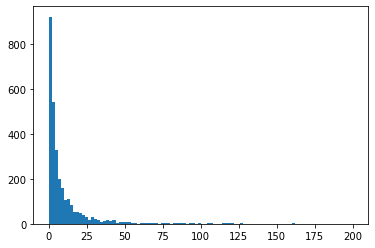

In [16]:
plt.hist(df['citations'], bins=100, range=(0,200));

In [18]:
#the target variable is again highly right-skewed
df['citations'].skew()

9.098907965034183

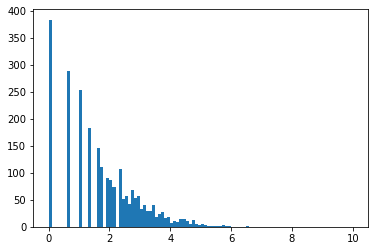

In [20]:
#Look at log distribution 
plt.hist(np.log(df['citations']), bins=100, range = (0,10));

In [32]:
df.describe()

,pmid,citations,len_text,len_title,days_live
count,2.986000e+03,2986.000000,2986.000000,2986.000000,2986.000000
mean,3.034788e+07,11.797053,1350.101474,83.965841,922.492297
std,2.748997e+06,29.680358,510.233430,29.963118,791.556287
min,1.996910e+07,0.000000,17.000000,12.000000,158.000000
25%,2.936660e+07,1.000000,998.250000,63.000000,341.000000
50%,3.115368e+07,4.000000,1298.500000,81.000000,677.000000
75%,3.232295e+07,11.000000,1651.000000,101.000000,1164.000000
max,3.394824e+07,704.000000,5876.000000,233.000000,4145.000000


### Remove Outliers

In [111]:
#check out outliers (posts that are three standard deviations above the mean)

In [34]:
num_columns = ['citations', 'len_text', 'len_title', 'days_live']

In [37]:
for col in num_columns: 
    print(f'{col} has {(df[col] > (df[col].mean()+(3*df[col].std()))).sum()} outliers.')

citations has 50 outliers.
len_text has 34 outliers.
len_title has 24 outliers.
days_live has 69 outliers.


In [38]:
df.shape

(2986, 8)

In [39]:
#drop outliers

for col in num_columns:
    df = df[(df[col] <= ((df[col].mean())+(3*(df[col].std()))))]

In [40]:
df.shape

(2809, 8)

In [41]:
df.describe()

,pmid,citations,len_text,len_title,days_live
count,2.809000e+03,2809.000000,2809.000000,2809.00000,2809.000000
mean,3.061512e+07,8.692417,1329.957992,83.40121,839.709505
std,2.352070e+06,14.176571,464.415876,28.45909,655.015418
min,2.207523e+07,0.000000,17.000000,12.00000,158.000000
25%,2.961473e+07,1.000000,1000.000000,63.00000,341.000000
50%,3.124898e+07,3.000000,1292.000000,81.00000,646.000000
75%,3.235154e+07,10.000000,1639.000000,101.00000,1072.000000
max,3.394824e+07,99.000000,2874.000000,173.00000,3233.000000


### Explore Relationships with Target Variable

#### Is the length of the abstract correlated with the target variable?

In [45]:
#check out some preliminary correlations
df['len_text']=df['text'].apply(len)
df['citations'].corr(df['len_text'])

-0.008637367792784411

No correlation here. 

In [46]:
#check out some preliminary correlations
df['len_title']=df['title'].apply(len)
df['citations'].corr(df['len_title'])

-0.057133632797256015

Citations do not appear correlated with the length of the title.

### Is there an effect of time on # of citations?

In [47]:
# convert date column to datetime object
df['date'] = pd.to_datetime(df['date'])

In [48]:
#sort the df in reverse chronological order
df.sort_values('date', inplace=True)

In [49]:
# create a new column that shows how long the posts had been live as of when they were pulled

df['days_live'] = (pd.to_datetime('2021-05-08') - df['date']).dt.days

In [50]:
# look at the correlation 
df['citations'].corr(df['days_live'])

0.4101367906991688

There does appear to be a positive correlation between the length of time that the article has existed with the number of citations. This makes sense. 

#### Log Citations

In [51]:
log_citations = pd.Series(np.log(df['citations']))

In [52]:
log_citations = np.isfinite(log_citations)

In [53]:
log_citations.corr(df['days_live'])

0.2983524772804706

Slightly weaker relationship here. 

### Can we establish a "highly-cited" category?

In [54]:
#if I want to turn this into a clf problem and use all posts with citations greater than 1 std above the mean....
sum(df['citations'] > df['citations'].mean() + df['citations'].std())

286

It's only about 10% of the data....I might need to adjust my criterion a bit. 

In [58]:
#if I want to turn this into a clf problem and use all posts with citations greater than 1 std above the mean....
sum(df['citations'] > 10)

678

The 75% threshold is 10, so that seems reasonable. Top quartile of articles. 

In [59]:
df['citations'].skew()

3.2601097193199666

The skew has improved without the outliers. 

In [60]:
df.to_csv('../data/pubmed_cleaned_no_outliers.csv')